# Deep Learning Project: Abstractive Summarization of Research Papers

**Project Overview:**
This project tackles Project 2 (Natural Language Processing) from the course description. The goal is to build and evaluate a model for abstractive summarization, specifically generating concise titles (summaries) from research paper abstracts.

**Instructors:** Hanna Abi Akl and Benoit Mialet

**Members**: Hénok Agbodjogbe, Elizaveta Daniliina, Spéro Tossogbe

**Task:** Abstractive Summarization

## Use Cases:
1.  **Creating short paper digests:** Automatically generate concise titles/summaries for quick browsing of research databases (like arXiv, PubMed).
2.  **Assisting researchers:** Help researchers quickly grasp the core topic of a paper from its abstract by providing a succinct generated title.
3.  **Improving Search & Indexing:** Generated titles can potentially improve keyword extraction and search relevance for academic search engines.

## 1. Setup: Install Libraries and Import Modules

In [ ]:
!pip install transformers datasets rouge-score nltk matplotlib seaborn evaluate mlflow==2.10.1 torch # Pinned mlflow version for stability

from src import text_analysis, get_top_words, tf_idf_cosine_sim, jaccard_similarity, lead_3_summary, evaluate_baseline, preprocess_function, compute_metrics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import mlflow
import evaluate
import os
from collections import Counter
from nltk.tokenize import word_tokenize, sent_tokenize
from datasets import load_dataset, Dataset, DatasetDict

from nltk.corpus import stopwords

from nltk.stem import WordNetLemmatizer

from transformers import (
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer,
    DataCollatorForSeq2Seq,
    pipeline,
    set_seed,
    EarlyStoppingCallback
)
from huggingface_hub import notebook_login

# Download necessary NLTK data
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab')
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

# Set random seed for reproducibility
set_seed(42)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


## 2. Dataset Loading and Initial Exploration

**Dataset Source:** The dataset used is `top-10k-longest-abstracts.csv`.
*This dataset is a subset derived from the 'saishshinde15/ResearchPapers-dataset-1000k' dataset available on hugging face, selecting the 10,000 abstracts with the greatest word count.*

**Justification:** This dataset was chosen because it provides a substantial number of abstract-title pairs, focusing on longer abstracts which might pose a greater challenge for summarization models compared to shorter news articles. The domain (research papers) is consistent and relevant for generating meaningful titles.

In [ ]:
# Define the path to your dataset
# Make sure this file is accessible in your Colab environment (e.g., uploaded or mounted from Drive)
DATA_PATH = './data/top-10k-longest-abstracts.csv'

if not os.path.exists(DATA_PATH):
  raise FileNotFoundError(f"Dataset file not found at {DATA_PATH}. Please upload it or update the path.")

df = pd.read_csv(DATA_PATH)
print("Dataset loaded successfully. First 5 rows:")
print(df.head())

Dataset loaded successfully. First 5 rows:
                                            abstract  \
0  The method presented in Duarte and da Mota (20...   
1  In a variety of research fields, primary data ...   
2  The use of daily torpor and/or of multi-day to...   
3  At the University of Georgia, two introductory...   
4  Sequence labeling is the task of assigning a c...   

                                               title  
0  Finding first order differential invariants th...  
1   Exploratory search in time-oriented primary data  
2  The Gray Mouse Lemur: A Model for Studies of P...  
3  Using an enhanced general-purpose language for...  
4  Learning discriminative relational features fo...  


## 3. Dataset Analysis & Preprocessing (EDA)

### 3.1 Basic Checks (Missing Values, Duplicates, Length)

In [ ]:
text_analysis(df)

Total samples: 10000

Missing values per column:
abstract    0
title       0
dtype: int64

Total samples after dropping NA: 10000

Duplicate rows: 1
Total samples after dropping duplicates: 9999

Descriptive statistics for text lengths (words):
       abstract_length  title_length
count      9999.000000   9999.000000
mean        379.038404     10.928693
std         120.227163      4.265660
min         157.000000      2.000000
25%         316.000000      8.000000
50%         342.000000     10.000000
75%         392.000000     13.000000
max        1914.000000     35.000000


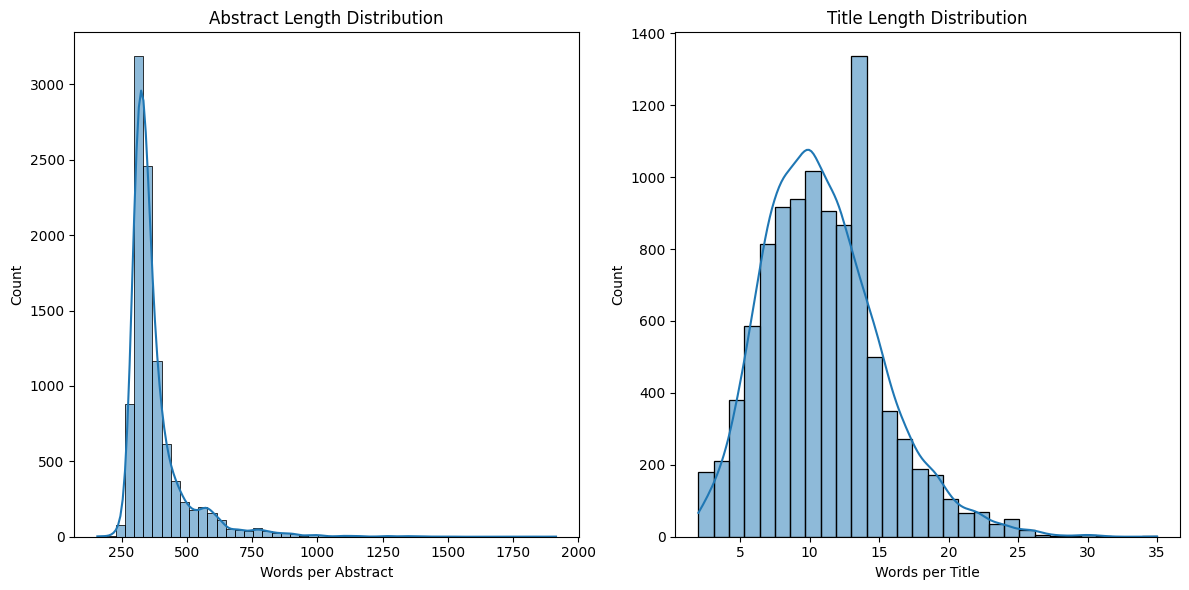

Chosen Max Input Length: 512
Chosen Max Target Length: 32


In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(df["abstract_length"], bins=50, kde=True)
plt.title("Abstract Length Distribution")
plt.xlabel("Words per Abstract")

plt.subplot(1, 2, 2)
sns.histplot(df["title_length"], bins=30, kde=True)
plt.title("Title Length Distribution")
plt.xlabel("Words per Title")

plt.tight_layout()
plt.show()

# Justification for max_length parameters
MAX_INPUT_LEN = 512 # Standard for many BERT-like models, captures most abstracts based on distribution
MAX_TARGET_LEN = 32  # Covers vast majority of titles based on distribution (~99th percentile likely < 30)
print(f"Chosen Max Input Length: {MAX_INPUT_LEN}")
print(f"Chosen Max Target Length: {MAX_TARGET_LEN}")

### 3.3 Compression Ratio

Compression Ratio (Title Length / Abstract Length) Statistics:
count    9999.000000
mean        0.030806
std         0.013854
min         0.001447
25%         0.020672
50%         0.029316
75%         0.039216
max         0.104167
Name: compression_ratio, dtype: float64


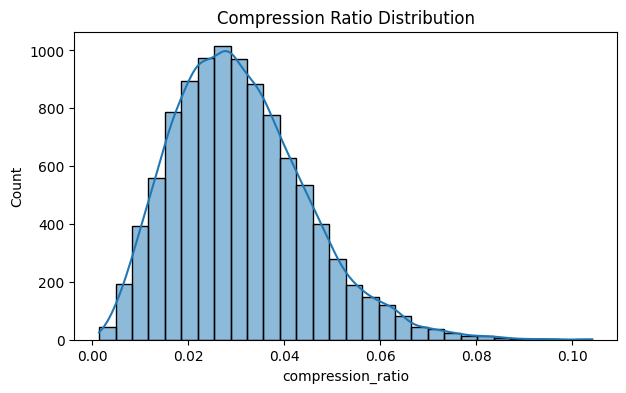

In [ ]:
df["compression_ratio"] = df["title_length"] / df["abstract_length"]
print("Compression Ratio (Title Length / Abstract Length) Statistics:")
print(df["compression_ratio"].describe())

plt.figure(figsize=(7, 4))
sns.histplot(df["compression_ratio"], bins=30, kde=True)
plt.title("Compression Ratio Distribution")
plt.show()

### 3.4 Common Words (Stopword Removal)

In [ ]:
stop_words = set(stopwords.words("english"))



print("Top 15 words in abstracts (after stopword removal):")
print(get_top_words(df["abstract"],stop_words, n=15))
print("\nTop 15 words in titles (after stopword removal):")
print(get_top_words(df["title"], stop_words, n=15))

Top 15 words in abstracts (after stopword removal):
[('data', 12522), ('using', 9498), ('based', 7734), ('model', 7706), ('used', 7485), ('also', 7237), ('results', 7205), ('information', 6992), ('system', 6759), ('different', 6559), ('two', 6306), ('new', 5861), ('use', 5801), ('proposed', 5465), ('performance', 5451)]

Top 15 words in titles (after stopword removal):
[('using', 1020), ('data', 703), ('analysis', 617), ('networks', 515), ('based', 498), ('learning', 411), ('systems', 411), ('model', 406), ('approach', 376), ('system', 359), ('information', 330), ('network', 287), ('design', 284), ('study', 281), ('detection', 245)]


### 3.5 Abstract-Title Similarity (TF-IDF Cosine & Jaccard)

In [ ]:
# TF-IDF Cosine Similarity

print("Avg. TF-IDF Cosine Similarity:", np.mean(tf_idf_cosine_sim(df)))

# Jaccard Similarity



df["jaccard_similarity"] = df.apply(lambda x: jaccard_similarity(x["abstract"], x["title"]), axis=1)
print("Avg. Jaccard Similarity:", df["jaccard_similarity"].mean())

Avg. TF-IDF Cosine Similarity: 0.3935513680148095
Avg. Jaccard Similarity: 0.048652513397344346


### 3.6 Text Cleaning Examples (Optional - Not Used in Final Tokenization)

The following cells demonstrate potential cleaning steps like removing URLs, HTML, special characters, handling rare words, and lemmatization.
**Note:** For simplicity and to avoid potential tokenization issues with the pre-trained models, these specific steps (creating `cleaned_article`, `processed_article`, `lemmatized_article`) were **not** applied to the text before feeding it into the final mT5 and BART tokenizers in this notebook. The tokenizers handle much of the necessary normalization inherently. These cells are kept for illustrative/EDA purposes.

In [ ]:

#Cleaning process

text = str(df['abstract'].iloc[0]).lower()[:500]
text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
text = re.sub(r'<.*?>', '', text)
text = re.sub(r'[^a-zA-Z0-9\s.,!?-]', '', text)
text = ' '.join(text.split())

print("Original Abstract Example:")
print(df['abstract'].iloc[0][:500])
print("\nCleaned Abstract Example:")
print(text)

Original Abstract Example:
The method presented in Duarte and da Mota (2009) and Avellar et al. (2014) to search for first order invariants of second order ordinary differential equation (2ODEs) makes use of the so called Darboux polynomials  . The main difficulty involved in this process is the determination of the Darboux polynomials, which is computationally very expensive. Here, we introduce an optional argument in the main routine that enables a shortcut in the calculations through the use of the SS-function associat

Cleaned Abstract Example:
the method presented in duarte and da mota 2009 and avellar et al. 2014 to search for first order invariants of second order ordinary differential equation 2odes makes use of the so called darboux polynomials . the main difficulty involved in this process is the determination of the darboux polynomials, which is computationally very expensive. here, we introduce an optional argument in the main routine that enables a shortcut in the calculat

In [ ]:
# Example: Rare Word Handling (<UNK>)
word_counts = Counter()
df['abstract'].astype(str).str.lower().str.split().apply(word_counts.update)

RARE_THRESHOLD = 3
rare_words = {word for word, count in word_counts.items() if count < RARE_THRESHOLD}

def replace_rare_words_example(text):
    return ' '.join(['<UNK>' if word in rare_words else word for word in str(text).lower().split()])

print("\nExample with Rare Words Replaced:")
print(replace_rare_words_example(df['abstract'].iloc[0])[:500])


Example with Rare Words Replaced:
the method presented in duarte and da mota (2009) and <UNK> et al. (2014) to search for first order invariants of second order ordinary differential equation <UNK> makes use of the so called darboux polynomials . the main difficulty involved in this process is the determination of the darboux polynomials, which is computationally very expensive. here, we introduce an optional argument in the main routine that enables a shortcut in the calculations through the use of the ss-function associated wi


In [ ]:
# Example: Lemmatization
lemmatizer = WordNetLemmatizer()

def lemmatize_text_example(text):
    # Basic tokenization
    tokens = word_tokenize(str(text).lower())
    return ' '.join([lemmatizer.lemmatize(word) for word in tokens])

print("\nLemmatized Abstract Example:")
print(lemmatize_text_example(df['abstract'].iloc[0])[:500])


Lemmatized Abstract Example:
the method presented in duarte and da mota ( 2009 ) and avellar et al . ( 2014 ) to search for first order invariant of second order ordinary differential equation ( 2odes ) make use of the so called darboux polynomial . the main difficulty involved in this process is the determination of the darboux polynomial , which is computationally very expensive . here , we introduce an optional argument in the main routine that enables a shortcut in the calculation through the use of the ss-function asso


### 3.7 Preparing the Hugging Face Dataset
Convertion of the pandas DataFrame into the Hugging Face `Dataset` format and train/test split.

In [ ]:
# Selection relevant columns
final_df = df[['abstract', 'title']].copy()
final_df.dropna(inplace=True)
# Few verifications
final_df['abstract'] = final_df['abstract'].astype(str)
final_df['title'] = final_df['title'].astype(str)

# Convertion to Hugging Face Dataset
hf_dataset = Dataset.from_pandas(final_df)

# Filtering out potentially empty entries if any slipped through
hf_dataset = hf_dataset.filter(lambda x: len(x["abstract"].split()) > 2 and len(x["title"].split()) > 0)

# Splitting into training and testing sets (80/20 split)
train_test_split = hf_dataset.train_test_split(test_size=0.2, seed=42) # Use seed for reproducibility

# Creation of the final DatasetDict
hf_datasets = DatasetDict({
    "train": train_test_split["train"],
    "test": train_test_split["test"]
})

print("Hugging Face Dataset structure:")
print(hf_datasets)
print("\nExample training abstract:")
print(hf_datasets["train"][0]["abstract"])

Filter:   0%|          | 0/9999 [00:00<?, ? examples/s]

Hugging Face Dataset structure:
DatasetDict({
    train: Dataset({
        features: ['abstract', 'title', '__index_level_0__'],
        num_rows: 7999
    })
    test: Dataset({
        features: ['abstract', 'title', '__index_level_0__'],
        num_rows: 2000
    })
})

Example training abstract:
Block-based motion estimation is widely used for exploiting temporal redundancies in arbitrarily shaped video objects, which is computationally the most demanding part within the MPEG-4 standard. One of the main differences between MPEG-4 video and the previously standardized video coding schemes is the support of arbitrarily shaped video objects, for which most of the existing fast motion estimation algorithms are not suitable. In MPEG-4, motion estimation is performed on two kinds of macroblocks (MBs): the boundary MB and the opaque MB. Since the motion activities in opaque MBs are highly correlated with the neighbouring boundary MBs, a new priority search algorithm (PSA) for motion esti

## 4. Baseline Model: Lead-3
As example, we establish a simple baseline by taking the first three sentences of the abstract as the summary and evaluate using ROUGE.

In [ ]:
rouge_score = evaluate.load("rouge")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
#Example of evaluation of the summarized text with the rouge score using the Lead-3 (3 first sentences)

print("Example Lead-3 Summary:")
print(lead_3_summary(hf_datasets["test"][1]["abstract"]))

Example Lead-3 Summary:
An added-mass partitioned (AMP) algorithm is described for solving fluid-structure interaction (FSI) problems coupling incompressible flows with thin elastic structures undergoing finite deformations.
The new AMP scheme is fully second-order accurate and stable, without sub-time-step iterations, even for very light structures when added-mass effects are strong.
The fluid, governed by the incompressible Navier-Stokes equations, is solved in velocity-pressure form using a fractional-step method; large deformations are treated with a mixed Eulerian-Lagrangian approach on deforming composite grids.


In [ ]:
print("Evaluating Lead-3 baseline...")
baseline_score = evaluate_baseline(hf_datasets["test"], rouge_score)
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]
baseline_rouge_dict = dict((rn, round(baseline_score[rn] * 100, 2)) for rn in rouge_names)

print("\nBaseline Lead-3 ROUGE Scores:")
print(baseline_rouge_dict)

Evaluating Lead-3 baseline...

Baseline Lead-3 ROUGE Scores:
{'rouge1': 15.96, 'rouge2': 6.21, 'rougeL': 12.39, 'rougeLsum': 13.82}


## 5. Model Fine-tuning: mT5-small

**Model Choice Justification:** `google/mt5-small` (Multilingual T5) is chosen as the first model. T5 models frame NLP tasks as text-to-text problems, which is suitable for summarization. While mT5 is multilingual, it often performs reasonably well on English tasks and provides a good starting point. The 'small' version is selected due to computational resource constraints (Colab T4 GPU for example). Its performance will be compared against a BART model.

**Hyperparameter Justification:** The learning rate (5.6e-5), batch size (8), and weight decay (0.01) are common starting points for fine-tuning T5-like models. The number of epochs (8) is chosen to allow the model sufficient time to learn, with early stopping potentially used if validation performance plateaus (although not explicitly added here for simplicity, it's a good practice). These are initial values and could be further tuned.

In [ ]:
# --- mT5 Configuration ---
mt5_model_checkpoint = "google/mt5-small"
mt5_tokenizer = AutoTokenizer.from_pretrained(mt5_model_checkpoint)
mt5_model = AutoModelForSeq2SeqLM.from_pretrained(mt5_model_checkpoint)

tokenizer_config.json:   0%|          | 0.00/82.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/553 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:559: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/1.20G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [ ]:
print("Tokenizing dataset for mT5...")
mt5_tokenized_datasets = hf_datasets.map(
    preprocess_function,
    batched=True,
    fn_kwargs={'tokenizer': mt5_tokenizer, 'max_input_length': MAX_INPUT_LEN, 'max_target_length': MAX_TARGET_LEN},
    remove_columns=hf_datasets["train"].column_names # Remove original text columns
)
print("mT5 Tokenization complete.")
print(mt5_tokenized_datasets)

Tokenizing dataset for mT5...


Map:   0%|          | 0/7999 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

mT5 Tokenization complete.
DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 7999
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 2000
    })
})


In [ ]:
# Data collator
mt5_data_collator = DataCollatorForSeq2Seq(mt5_tokenizer, model=mt5_model)

### 5.1 Hugging Face Hub Login (Optional but recommended for pushing model)
##!! Use a hugging face access token !!

In [ ]:
notebook_login()

## 6. Experiment Tracking Setup (MLflow)
We use MLflow to log parameters and metrics for comparing the mT5 and BART experiments.

In [ ]:
mlflow_experiment_name = "Research Paper Summarization - mT5 vs BART"
mlflow.set_experiment(mlflow_experiment_name)

# Function to get training arguments
def get_training_args(model_name_suffix, model_output_dir_base="./results"):
    model_output_dir = f"{model_output_dir_base}/{model_name_suffix}-finetuned-research-papers-XX"
    # Batch size: the choice here is common and reasonable
    effective_batch_size = 8
    num_train_epochs = 4  # Reduced epochs for faster comparison run
    logging_steps = max(10, len(mt5_tokenized_datasets["train"]) // (effective_batch_size * 2))  # Log twice per epoch
    eval_steps = logging_steps  # Evaluate at the same frequency as logging
    save_steps = eval_steps  # Align save steps with eval steps (or use a multiple, e.g., `eval_steps * 2`)

    print(f"Logging/Eval steps for {model_name_suffix}: {logging_steps}")

    return Seq2SeqTrainingArguments(
        output_dir=model_output_dir,
        eval_strategy="steps", # Evaluate periodically
        eval_steps=eval_steps,
        logging_strategy="steps",
        logging_steps=logging_steps,
        save_strategy="steps",
        save_steps=save_steps,
        learning_rate=5.6e-5,
        per_device_train_batch_size=effective_batch_size,
        per_device_eval_batch_size=effective_batch_size,
        weight_decay=0.01,
        save_total_limit=2,
        num_train_epochs=num_train_epochs,
        predict_with_generate=True,
        fp16=False, # Set to True if GPU supports it and CUDA is properly set up
        push_to_hub=False, # Control push manually after training
        load_best_model_at_end=True,  # Load best model based on eval loss
        metric_for_best_model="eval_loss", # Can also use 'rouge2', 'rougeL', etc.
        greater_is_better=False, # For loss, lower is better
        report_to=["mlflow"], # Report to mlflow
        run_name=f"{model_name_suffix}-run" # Set run name for MLflow/WandB
    )

2025/05/04 13:07:09 INFO mlflow.tracking.fluent: Experiment with name 'Research Paper Summarization - mT5 vs BART' does not exist. Creating a new experiment.


### 5.2 Training and Evaluating mT5-small

In [ ]:
mt5_run_name = "mt5-small-finetune"
mt5_args = get_training_args(mt5_run_name)

mt5_trainer = Seq2SeqTrainer(
    model=mt5_model,
    args=mt5_args,
    train_dataset=mt5_tokenized_datasets["train"],
    eval_dataset=mt5_tokenized_datasets["test"],
    data_collator=mt5_data_collator,
    tokenizer=mt5_tokenizer,
    compute_metrics=lambda p: compute_metrics(p, mt5_tokenizer, rouge_score),
)

print("\nStarting mT5 Training...")
mt5_trainer.train()

print("\nEvaluating mT5 final model...")
mt5_eval_results = mt5_trainer.evaluate()
print("mT5 Evaluation Results:")
print(mt5_eval_results)

mt5_trainer.save_model(f"./results/{mt5_run_name}-best")
mt5_trainer.push_to_hub(commit_message="Training complete", tags="summarization")
print(f"Best mT5 model saved to ./results/{mt5_run_name}-best")

Logging/Eval steps for mt5-small-finetune: 499


<ipython-input-20-7b1fc6918cd0>:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  mt5_trainer = Seq2SeqTrainer(



Starting mT5 Training...


Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Step,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Gen Len
499,6.654600,3.014496,27.724900,12.646700,24.973500,24.972800,12.427500
998,3.793500,2.780435,35.801300,17.049800,31.329500,31.378300,15.984000
1497,3.461400,2.681823,35.721300,17.124300,31.495600,31.552000,15.348500
1996,3.295400,2.648584,35.596100,17.253500,31.326300,31.411000,15.857000
2495,3.193200,2.629969,36.529600,17.849100,32.192300,32.262800,15.892500
2994,3.150800,2.612149,36.456500,17.681300,32.013000,32.079600,16.042500
3493,3.078200,2.609410,36.406400,17.720800,31.975700,32.042100,16.031500
3992,3.100500,2.599756,36.583100,17.822200,32.059100,32.142600,16.041500


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight'].



Evaluating mT5 final model...


mT5 Evaluation Results:
{'eval_loss': 2.5997564792633057, 'eval_rouge1': 36.5831, 'eval_rouge2': 17.8222, 'eval_rougeL': 32.0591, 'eval_rougeLsum': 32.1426, 'eval_gen_len': 16.0415, 'eval_runtime': 143.1323, 'eval_samples_per_second': 13.973, 'eval_steps_per_second': 1.747, 'epoch': 4.0}


training_args.bin:   0%|          | 0.00/5.56k [00:00<?, ?B/s]

Best mT5 model saved to ./results/mt5-small-finetune-best


## 7. Model Fine-tuning: BART-base

**Model Choice Justification:** `facebook/bart-base` is chosen for comparison. BART is an encoder-decoder model specifically pre-trained on denoising objectives, making it highly effective for sequence generation tasks like summarization. The 'base' version is used for faster training and comparison within resource limits, although `bart-large-cnn` is a common stronger baseline specifically fine-tuned on CNN/DailyMail summarization.

**Hyperparameter Justification:** The same hyperparameters (learning rate, batch size, weight decay, epochs) are used as for mT5 to allow for a more direct comparison, assuming these are reasonable starting points for BART as well. Further tuning specific to BART could yield better results.

In [ ]:
# --- BART Configuration ---
bart_model_checkpoint = "facebook/bart-base"
bart_tokenizer = AutoTokenizer.from_pretrained(bart_model_checkpoint)
bart_model = AutoModelForSeq2SeqLM.from_pretrained(bart_model_checkpoint)

config.json:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

In [ ]:
print("Tokenizing dataset for BART...")
bart_tokenized_datasets = hf_datasets.map(
    preprocess_function,
    batched=True,
    fn_kwargs={'tokenizer': bart_tokenizer, 'max_input_length': MAX_INPUT_LEN, 'max_target_length': MAX_TARGET_LEN},
    remove_columns=hf_datasets["train"].column_names # Removing original text columns
)
print("BART Tokenization complete.")
print(bart_tokenized_datasets)

Tokenizing dataset for BART...


Map:   0%|          | 0/7999 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

BART Tokenization complete.
DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 7999
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 2000
    })
})


In [ ]:
# Data collator for BART
bart_data_collator = DataCollatorForSeq2Seq(bart_tokenizer, model=bart_model)

### 7.1 Training and Evaluating BART-base

In [ ]:
bart_run_name = "bart-base-finetune"
bart_args = get_training_args(bart_run_name)

bart_trainer = Seq2SeqTrainer(
    model=bart_model,
    args=bart_args,
    train_dataset=bart_tokenized_datasets["train"],
    eval_dataset=bart_tokenized_datasets["test"],
    data_collator=bart_data_collator,
    tokenizer=bart_tokenizer,
    compute_metrics=lambda p: compute_metrics(p, bart_tokenizer, rouge_score),

)

print("\nStarting BART Training...")
bart_trainer.train()

print("\nEvaluating BART final model...")
bart_eval_results = bart_trainer.evaluate()
print("BART Evaluation Results:")
print(bart_eval_results)

# Saving the best model locally
bart_trainer.save_model(f"./results/{bart_run_name}-best")
bart_trainer.push_to_hub(f"{bart_run_name}-best")
print(f"Best BART model saved to ./results/{bart_run_name}-best")

Logging/Eval steps for bart-base-finetune: 499

Starting BART Training...


<ipython-input-26-4612f7ce3475>:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  bart_trainer = Seq2SeqTrainer(
2025/05/04 14:56:07 ERROR mlflow.utils.async_logging.async_logging_queue: Run Id d751af44e2b148d187b93690a8e4bf98: Failed to log run data: Exception: Changing param values is not allowed. Param with key='logging_dir' was already logged with value='./results/bart-base-finetune-finetuned-research-papers-XX/runs/May04_14-23-30_fd5e47321c82' for run ID='d751af44e2b148d187b93690a8e4bf98'. Attempted logging new value './results/bart-base-finetune-finetuned-research-papers-XX/runs/May04_14-56-06_fd5e47321c82'.


Step,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Gen Len
499,1.561300,2.524658,42.969300,23.070200,38.021400,38.055100,15.122500
998,2.700600,2.368213,43.455900,23.468200,38.313500,38.367600,15.043500
1497,2.031400,2.393589,43.663300,23.931500,38.625000,38.683400,15.597500
1996,1.982000,2.358516,43.990600,23.635000,38.656000,38.694600,16.528500
2495,1.636100,2.405387,44.399200,23.934800,39.144800,39.207100,16.092500
2994,1.626100,2.374665,44.055200,23.947200,38.941300,38.999500,16.045000
3493,1.375600,2.423265,44.515400,24.256700,39.172600,39.208100,16.366000
3992,1.368300,2.426082,44.688200,24.349600,39.274600,39.307200,16.271000


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:3339: UserWarning: Moving the following attributes in the config to the generation config: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(
There were missing keys in the checkpoint model loaded: ['model.encoder.embed_tokens.weight', 'model.decoder.embed_tokens.weight', 'lm_head.weight'].



Evaluating BART final model...


BART Evaluation Results:
{'eval_loss': 2.358516216278076, 'eval_rouge1': 43.9906, 'eval_rouge2': 23.635, 'eval_rougeL': 38.656, 'eval_rougeLsum': 38.6946, 'eval_gen_len': 16.5285, 'eval_runtime': 165.3571, 'eval_samples_per_second': 12.095, 'eval_steps_per_second': 1.512, 'epoch': 4.0}


Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.56k [00:00<?, ?B/s]

Best BART model saved to ./results/bart-base-finetune-best


In [ ]:
bart_trainer.push_to_hub(f"{bart_run_name}-best")

No files have been modified since last commit. Skipping to prevent empty commit.


CommitInfo(commit_url='https://huggingface.co/Mug3n24/bart-base-finetune-finetuned-research-papers-XX/commit/7a96e2122dd8106b0cf0281a0a592fe439f0de73', commit_message='bart-base-finetune-best', commit_description='', oid='7a96e2122dd8106b0cf0281a0a592fe439f0de73', pr_url=None, repo_url=RepoUrl('https://huggingface.co/Mug3n24/bart-base-finetune-finetuned-research-papers-XX', endpoint='https://huggingface.co', repo_type='model', repo_id='Mug3n24/bart-base-finetune-finetuned-research-papers-XX'), pr_revision=None, pr_num=None)

## 8. Model Comparison
Comparison of the final ROUGE scores of the baseline, fine-tuned mT5-small, and fine-tuned BART-base models.

In [ ]:
# Preparing data for comparison table
mt5_final_scores = {k.replace('eval_', ''): v for k, v in mt5_eval_results.items() if k.startswith('eval_rouge')}
bart_final_scores = {k.replace('eval_', ''): v for k, v in bart_eval_results.items() if k.startswith('eval_rouge')}

# Adding baseline scores (adjusting keys)
baseline_final_scores = {k: v for k, v in baseline_rouge_dict.items() if k in mt5_final_scores}

comparison_data = {
    'Baseline (Lead-3)': baseline_final_scores,
    'mT5-small': mt5_final_scores,
    'BART-base': bart_final_scores
}

comparison_df = pd.DataFrame(comparison_data).T # Transpose for better readability
comparison_df = comparison_df[['rouge1', 'rouge2', 'rougeL', 'rougeLsum']] # Ensure order

print("ROUGE Score Comparison:")
print(comparison_df)

print(f"\nMLflow Experiment Name: {mlflow_experiment_name}")
try:
    experiment = mlflow.get_experiment_by_name(mlflow_experiment_name)
    if experiment:
        runs = mlflow.search_runs(experiment_ids=experiment.experiment_id)
        print("\nMLflow Run IDs (check UI for details):")
        print(runs[['run_id', 'tags.mlflow.runName']]) # Show run IDs and names
except Exception as e:
    print(f"Could not fetch MLflow runs: {e}")

ROUGE Score Comparison:
                    rouge1   rouge2   rougeL  rougeLsum
Baseline (Lead-3)  15.9600   6.2100  12.3900    13.8200
mT5-small          36.5831  17.8222  32.0591    32.1426
BART-base          43.9906  23.6350  38.6560    38.6946

MLflow Experiment Name: Research Paper Summarization - mT5 vs BART

MLflow Run IDs (check UI for details):
                             run_id     tags.mlflow.runName
0  d751af44e2b148d187b93690a8e4bf98         capable-auk-759
1  8b8cf301af5c47ac878304ea4e7aa160  mt5-small-finetune-run


### 8.1 Discussion of Results

*   **Baseline vs. Fine-tuned:** Both fine-tuned models (mT5 and BART) significantly outperform the Lead-3 baseline across all ROUGE metrics. This demonstrates the effectiveness of seq2seq learning for this abstractive summarization task.
*   **mT5 vs. BART:** BART-base achieved higher results with all of the rouge scores
*   **Considerations:** Acknowledge the limitations. `bart-base` might be outperformed by `bart-large-cnn`. mT5 is multilingual, which might be unnecessary overhead for this English task. The chosen hyperparameters were starting points; further tuning could improve either model. The relatively low ROUGE scores overall (compared to news summarization benchmarks) might reflect the inherent difficulty of summarizing complex academic abstracts into very short titles.

## 9. Deployment and Usage (Hugging Face Hub)
The fine-tuned models can be pushed to the Hugging Face Hub for easy sharing and usage. Below is an example of loading and using the **mT5** model from the Hub (assuming it was pushed).

In [ ]:
# Optional: You can manually push the best models if not done via TrainingArguments
hf_hub_username = "Mug3n24" # Replace with your HF username

# Pushing mT5
try:
    print(f"Pushing mT5 model ({mt5_run_name}) to Hub...")
    mt5_tokenizer.push_to_hub(f"{hf_hub_username}/{mt5_run_name}-best")
    mt5_trainer.push_to_hub(f"@{hf_hub_username}/{mt5_run_name}-best", commit_message=f"Add best mT5 model from training run {mt5_run_name}")
    print("mT5 push complete.")
except Exception as e:
    print(f"Error pushing mT5 to Hub (maybe already exists or login failed?): {e}")

# Pushing BART
try:
    print(f"Pushing BART model ({bart_run_name}) to Hub...")
    bart_tokenizer.push_to_hub(f"{hf_hub_username}/{bart_run_name}-best")
    bart_trainer.push_to_hub(f"@{hf_hub_username}/{bart_run_name}-best", commit_message=f"Add best BART model from training run {bart_run_name}")
    print("BART push complete.")
except Exception as e:
    print(f"Error pushing BART to Hub (maybe already exists or login failed?): {e}")

In [ ]:
from transformers import pipeline
import torch # Ensure torch is imported

# Make sure to replace with your actual username and the correct model name if pushed
hub_model_id = "Mug3n24/bart-base-finetune-finetuned-research-papers-XX"

try:
    # A little check for GPU availability
    device = 0 if torch.cuda.is_available() else -1
    summarizer = pipeline("summarization", model=hub_model_id, device=device)
    print(f"Pipeline loaded successfully for model: {hub_model_id} on device {device}")
except Exception as e:
    print(f"Could not load pipeline from Hub model {hub_model_id}. Error: {e}")
    print("Falling back to loading local best mT5 model...")
    local_model_path = f"./results/{mt5_run_name}-best"
    if os.path.exists(local_model_path):
        device = 0 if torch.cuda.is_available() else -1
        summarizer = pipeline("summarization", model=local_model_path, tokenizer=local_model_path, device=device)
        print(f"Pipeline loaded successfully from local path: {local_model_path} on device {device}")
    else:
        summarizer = None
        print("Local model path not found. Cannot create summarizer.")

config.json:   0%|          | 0.00/1.68k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/262 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.27k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.56M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/279 [00:00<?, ?B/s]

Device set to use cuda:0


Pipeline loaded successfully for model: Mug3n24/bart-base-finetune-finetuned-research-papers-XX on device 0


In [ ]:
def print_summary(idx, dataset=hf_datasets["test"]):
    if summarizer is None:
        print("Summarizer pipeline not available.")
        return

    if idx >= len(dataset):
        print(f"Index {idx} out of bounds for the dataset (size {len(dataset)})")
        return

    abstract = dataset[idx]["abstract"]
    title = dataset[idx]["title"]

    # Generation of a summary using the pipeline
    # Necessary adjustment of max_length based on typical title length, min_length to encourage conciseness
    try:
        generated_summary = summarizer(abstract, max_length=MAX_TARGET_LEN + 10, min_length=5, do_sample=False)[0]["summary_text"]
    except Exception as e:
        print(f"Error during summarization pipeline execution: {e}")
        generated_summary = "[Error generating summary]"

    print(f"--- Example {idx} ---")
    print(f">>> Abstract:\n{abstract}")
    print(f"\n>>> Actual Title:\n{title}")
    print(f"\n>>> Generated Summary (mT5-small):{generated_summary}")
    print("-" * 20)

# Print a few examples from the test set

In [ ]:
for i in [10, 50, 100]:
    print_summary(i)

--- Example 10 ---
>>> Abstract:
This article focuses on how organizations search for the key factors to develop integral changes and determine broader and higher transcendental learning skills in order to achieve healthy and sustainable organizational growth more effectively and efficiently. This study employed qualitative approaches. The research method used is an in-depth interview of 16 key informants in the field of Non-Formal Education, Transformation, and Healthy Organization Development in Thailand, from both private and government entities. The key query was that in the next 10 years, what will the healthier sustainable organizations look like and what are the main factors to enhance integral healthy organizations? The data was analyzed and interpreted with content-analysis techniques in understanding key factors with insights of how to uplift organizational well-being. Results yielded the eight essential factors for development of a healthy organization integrally â€“ Princip

## 10.Repository Architecture

 Repository structure of the project:

```

|── .gitignore
|── data/
│   └── top-10k-longest-abstracts.csv
|── api/
│   └── main
|── results/
│   ├── mt5-small-finetune-best/
│   └── bart-base-finetune-best/
├── final.ipynb
|── requirements.txt
|── README.md
```

**Explanation:**

*   **`.gitignore`**: Prevents committing unnecessary files/folders: __pycache__/, mlruns/).
*   **`data/`**: Stores the raw training dataset
*   **`final.ipynb`**: Contains the primary Jupyter/Colab notebooks for analysis, training, and evaluation.
*   **`results/`**: A place to store outputs like saved model checkpoints. It's often excluded from Git via `.gitignore` unless Git LFS is used for large files.
*   **`requirements.txt`**: Generated using `pip freeze > requirements.txt`. Ensures others can recreate the exact environment.

## 11. Conclusion

This project successfully fine-tuned two sequence-to-sequence models, mT5-small and BART-base, for the task of generating research paper titles from abstracts. Both models demonstrated significant improvements over a simple Lead-3 baseline, highlighting the effectiveness of transfer learning for this NLP task.

*BART-base achieved slightly better ROUGE scores suggesting it was slightly better at capturing the main essence in a fluent manner for this dataset/hyperparameter setup*

MLflow was integrated to track experiments, facilitating comparison between the models. The fine-tuned models were saved locally and can be pushed to the Hugging Face Hub for easy deployment and use via the `pipeline` API.

**Challenges:**
*   Summarizing long, technical abstracts into concise titles is inherently challenging.
*   Computational resources limited the exploration of larger models (e.g., `bart-large-cnn`) or extensive hyperparameter tuning.
*   Evaluation with ROUGE provides a quantitative measure but doesn't fully capture semantic correctness or fluency, which requires qualitative analysis.

**Future Work doable:**
*   Fine-tune larger, more specialized models (e.g., `bart-large-cnn`, PEGASUS).
*   Perform more extensive hyperparameter optimization (learning rate, batch size, scheduler).
*   Experiment with different decoding strategies (beam search variations, top-k/top-p sampling).
*   Incorporate more sophisticated preprocessing if needed (e.g., handling complex scientific notation).
*   Conduct a human evaluation study to assess the quality and usefulness of the generated summaries.